In [1]:
import os
import io

import detectron2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import numpy as np
import cv2
import torch

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# Load VG Classes
data_path = 'data/genome/1600-400-20'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())

vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())


MetadataCatalog.get("vg").thing_classes = vg_classes
MetadataCatalog.get("vg").attr_classes = vg_attrs

In [3]:
cfg = get_cfg()
cfg.merge_from_file("../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
# VG Weight
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"
predictor = DefaultPredictor(cfg)

Config '../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



In [6]:
# coding=utf-8
# Copyleft 2019 Project LXRT

import sys
import csv
import base64
import time

import numpy as np

csv.field_size_limit(sys.maxsize)
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]


def load_obj_tsv(fname, topk=None):
    """Load object features from tsv file.

    :param fname: The path to the tsv file.
    :param topk: Only load features for top K images (lines) in the tsv file.
        Will load all the features if topk is either -1 or None.
    :return: A list of image object features where each feature is a dict.
        See FILENAMES above for the keys in the feature dict.
    """
    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        for i, item in enumerate(reader):

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])
            
            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes, ), np.int64),
                ('objects_conf', (boxes, ), np.float32),
                ('attrs_id', (boxes, ), np.int64),
                ('attrs_conf', (boxes, ), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                item[key] = item[key].reshape(shape)
                item[key].setflags(write=False)

            data.append(item)
            if topk is not None and len(data) == topk:
                break
    elapsed_time = time.time() - start_time
    print("Loaded %d images in file %s in %d seconds." % (len(data), fname, elapsed_time))
    return data

data = load_obj_tsv('data/caffe_coco_features/train2014_obj36.tsv')


Start to load Faster-RCNN detected objects from data/caffe_coco_features/train2014_obj36.tsv
Loaded 10 images in file data/caffe_coco_features/train2014_obj36.tsv in 0 seconds.


In [26]:
NUM_OBJECTS = 36

from torch import nn

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image
from detectron2.structures.boxes import Boxes
from detectron2.structures.instances import Instances

def doit(raw_image, raw_boxes):
        # Process Boxes
    raw_boxes = Boxes(torch.from_numpy(raw_boxes).cuda())
    
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
#         print("Original image size: ", (raw_height, raw_width))
        
        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
#         print("Transformed image size: ", image.shape[:2])
        
        # Scale the box
        new_height, new_width = image.shape[:2]
        scale_x = 1. * new_width / raw_width
        scale_y = 1. * new_height / raw_height
        #print(scale_x, scale_y)
        boxes = raw_boxes.clone()
        boxes.scale(scale_x=scale_x, scale_y=scale_y)
        
        # ----
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)
        
        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)
        
        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [boxes]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
#         print('Pooled features size:', feature_pooled.shape)
        
        # Predict classes        pred_class_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled) and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        pred_class_prob = nn.functional.softmax(pred_class_logits, -1)
        pred_scores, pred_classes = pred_class_prob[..., :-1].max(-1)
        
        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)
        
        # Detectron2 Formatting (for visualization only)
        roi_features = feature_pooled
        instances = Instances(
            image_size=(raw_height, raw_width),
            pred_boxes=raw_boxes,
            scores=pred_scores,
            pred_classes=pred_classes,
            attr_scores = max_attr_prob,
            attr_classes = max_attr_label
        )
        
        return instances, roi_features
    


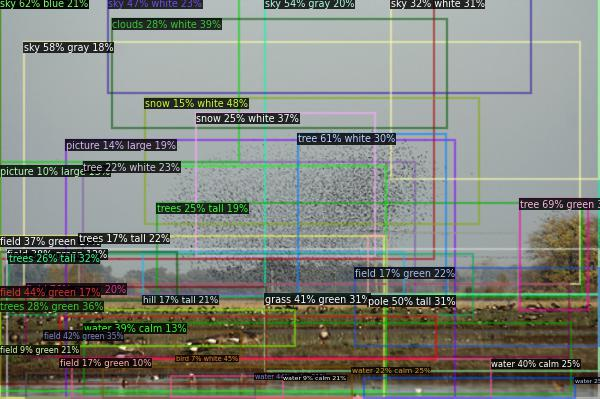

Feature Differences: 0.016179742
Object Ids Differences: 8
Attribute Ids Differences: 9


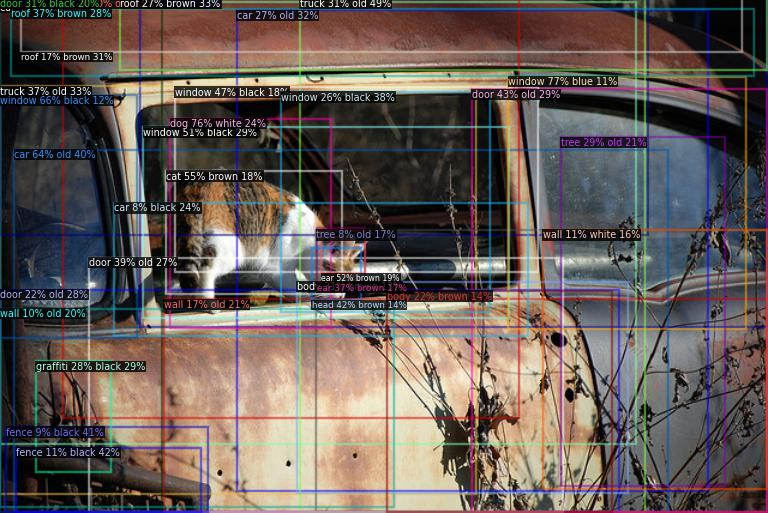

Feature Differences: 0.01575517
Object Ids Differences: 8
Attribute Ids Differences: 3


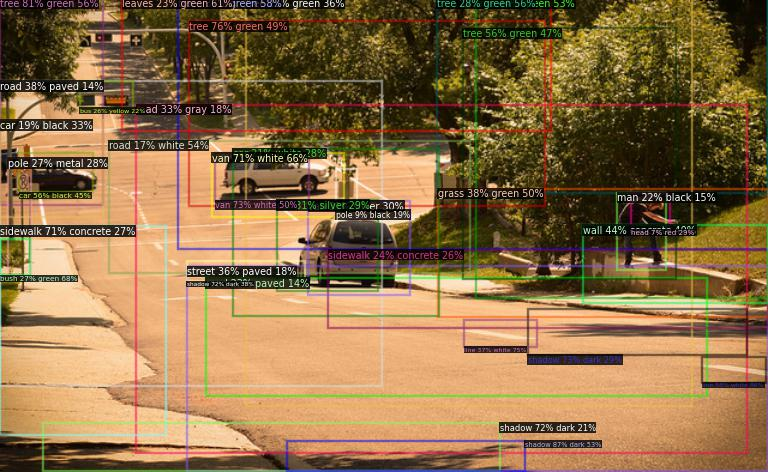

Feature Differences: 0.0174966
Object Ids Differences: 5
Attribute Ids Differences: 8


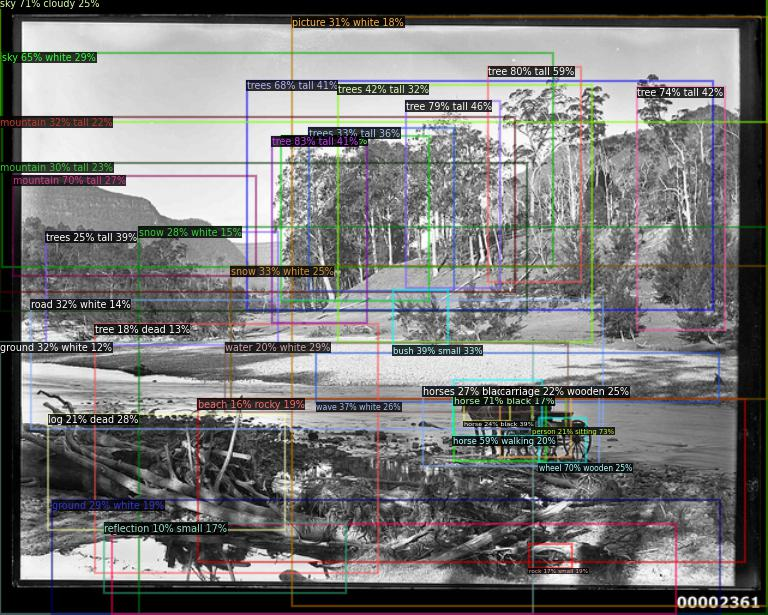

Feature Differences: -0.0010334329
Object Ids Differences: 5
Attribute Ids Differences: 7


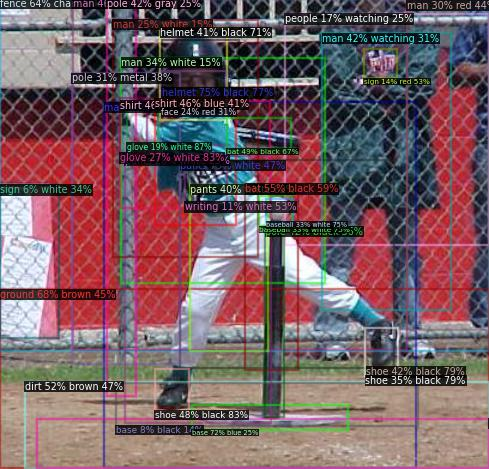

Feature Differences: 0.036905132
Object Ids Differences: 8
Attribute Ids Differences: 5


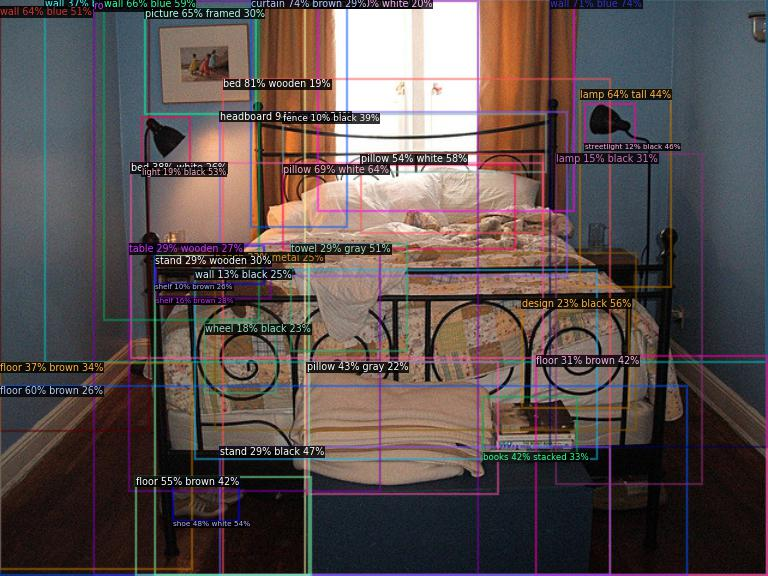

Feature Differences: 0.01768159
Object Ids Differences: 7
Attribute Ids Differences: 3


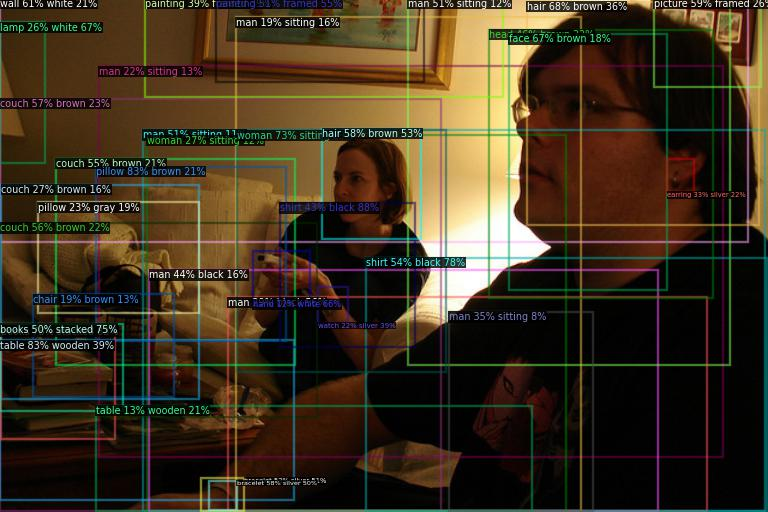

Feature Differences: 0.023268906
Object Ids Differences: 5
Attribute Ids Differences: 3


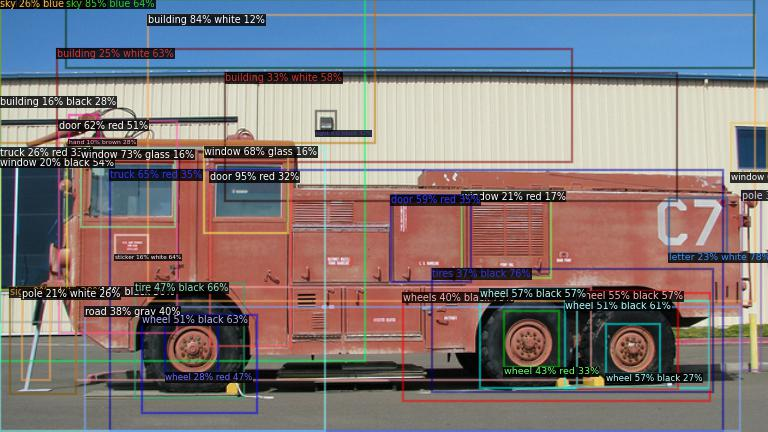

Feature Differences: 0.018676879
Object Ids Differences: 5
Attribute Ids Differences: 4


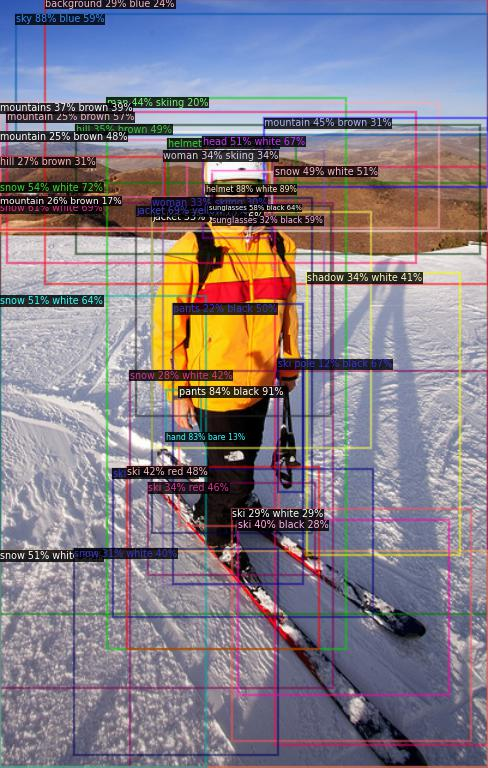

Feature Differences: 0.015090186
Object Ids Differences: 7
Attribute Ids Differences: 1


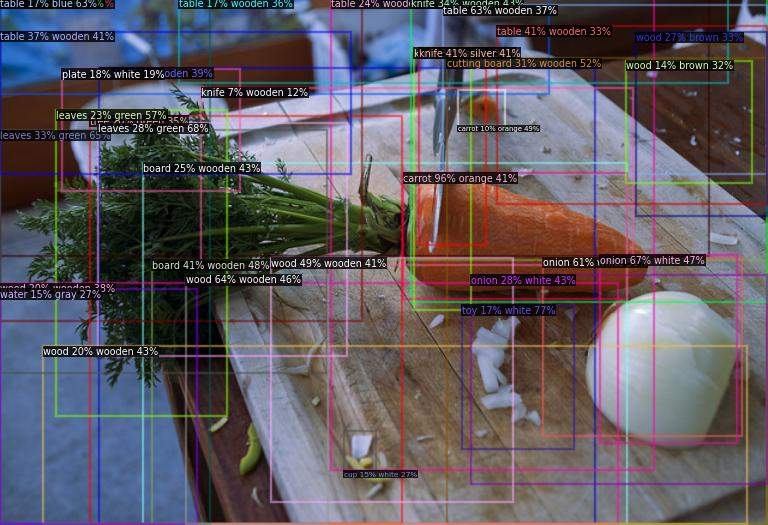

Feature Differences: 0.0015243064
Object Ids Differences: 11
Attribute Ids Differences: 2


In [27]:
# Show the boxes, labels, and features
#FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              #"attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]
for datum in data:
    im = cv2.imread('data/images/' + datum['img_id'] + '.jpg')
    given_boxes = datum['boxes']
    instances, features = doit(im, given_boxes)
    pred = instances.to('cpu')
    v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
    v = v.draw_instance_predictions(pred)
    showarray(v.get_image()[:, :, ::-1])
    print("Feature Differences:", (features.cpu().numpy() - datum['features']).mean())
    print("Object Ids Differences:", (instances.pred_classes.cpu().numpy() != datum['objects_id']).sum())
    print("Attribute Ids Differences:", (instances.attr_classes.cpu().numpy() != datum['attrs_id']).sum())
    
